In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import pysixtracklib as pyst
from pysixtracklib import stcommon as st

In [3]:
from scipy.constants import e, m_p, c

In [4]:
import sys
sys.path = ["/home/HPC/oeftiger/PyHEADTAIL_py3/python3/PyHEADTAIL/", 
            "/home/HPC/oeftiger/PyHEADTAIL_py3/"] + sys.path

In [5]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [6]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.general.contextmanager import GPU

PyHEADTAIL v1.13.1


PyPIC v2.4.1
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [7]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [8]:
n_macroparticles = int(1e6)
n_slices_sc = 32

# fixed field map for space charge
n_mesh_nodes = 256
n_mesh_sigma = 8

intensity = 2.95e10
eps4g_x = 12.57e-6 # in [m.rad]
eps4g_y = 9.30e-6 # in [m.rad]
bunch_length = 3472.7e-9 # in [s]
sigma_dp = 1e-15 #2.5e-4/3.

#p0c = 6 * 1e9 # in eV
p0c = 146.501e6 # in eV

Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (m_p * c))**2)
beta = np.sqrt(1 - gamma**-2)
epsn_x = beta * gamma * eps4g_x / 4
epsn_y = beta * gamma * eps4g_y / 4
sigma_z = beta * c * bunch_length / 4. # in [m]
# beta_z = 1 #np.abs(eta) * circumference / (2 * np.pi * Qs)
beta_z = sigma_z / sigma_dp
epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [9]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

# Preparing lattice

In [10]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.06.26 18:40:46      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [11]:
madx.call(file="sis18_thin.seq")

In [12]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [13]:
madx.use(sequence="FODO")

In [14]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155171         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -27.77757364        15.52637808        15.73920614 

             dxrms             xcomax             xcorms                 q2 
       11.86024141                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
      -38.70812931        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [15]:
circumference = twiss.summary.length
assert circumference == twiss['s'][-1]

In [16]:
# madx.input('''
# USE, sequence=FODO;
# ! select, flag=seqedit, class=instrument;
# ! select, flag=seqedit, class=marker;
# SEQEDIT, sequence=FODO;
#     ! remove, element=selected;
#     remove, element=FODO$START;
#     remove, element=FODO$END;
#     flatten;
# ENDEDIT;
# USE, sequence=FODO;
# ''')

# Inject SC markers to compute TWISS functions in these places

In [17]:
n_scnodes = 5*20
l_target = circumference / n_scnodes
l_fuzz = l_target / 2.

l_target

2.1670814039999997

In [18]:
madx.input('sc_placeholder: Marker;')

True

In [19]:
madx.command.seqedit(sequence='FODO')

True

In [20]:
# remove FODO$start marker, otherwise this space charge node would have 0 length
for i in range(1, len(twiss['name'])):
    el_name = twiss['name'][i]
    s = twiss['s'][i]
    l = twiss['l'][i]
    if not 'drift' in el_name:
        madx.command.install(element='sc_placeholder', at=s)
    else:
        if l < l_target + l_fuzz:
            continue
        l_remaining = l
        s_insert = s - l
        while l_remaining > l_target:
            s_insert += l_target
            madx.command.install(element='sc_placeholder', at=s_insert)
            l_remaining -= l_target

In [21]:
madx.command.flatten()

True

In [22]:
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  577
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [23]:
madx.use(sequence='FODO')

In [24]:
twiss = madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155171         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -27.77757364        15.52637808        15.73920614 

             dxrms             xcomax             xcorms                 q2 
       11.91064349                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
      -38.70812931        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [25]:
# madx.input("""
# myvalue(xx,yy,zz): macro = {myval = table(xx,yy,zz);};

# sc_placeholder : Marker; 
# option, -info;
# l_target = """ + str(l_target) + """;
# l_fuzz = l_target/2.;
# rows = table(twiss,tablelength);
# seqedit, sequence=FODO;
# while(i<rows){
#     !!! from Adrian:
#     exec, myvalue(twiss,s,$i);
#     install, element=sc_placeholder, at=myval;
    
#     !!! Hannes' loop starts here:
#     i = i+1;
#     exec, myvalue(twiss,l,$i);
#     length = myval;
#     if(length > l_target + l_fuzz){
#         ! value, length;
#         l_remaining = length;
#         exec, myvalue(twiss,s,$i);
#         s = myval - length;
#         while (l_remaining > l_target){
#             s = s + l_target;
#             value, s;
#             install, element=sc_placeholder, at=s;
#             l_remaining = l_remaining - l_target;
#         }
#     }
# }
# flatten;
# option, info;
# endedit;
# """)

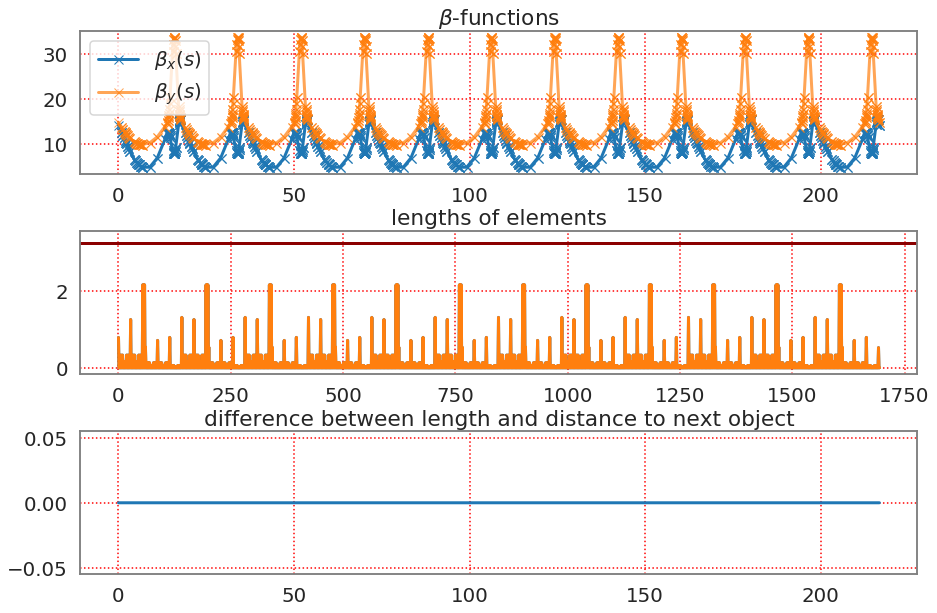

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

plt.sca(ax[0])
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.legend()

plt.sca(ax[1])
plt.title('lengths of elements')
plt.plot(np.diff(twiss['s']))
plt.plot(twiss['l'][1:])
plt.axhline(l_target*1.5, color='darkred')
plt.ylim(top=l_target*1.5*1.1)

plt.sca(ax[2])
plt.title('difference between length and distance to next object')
plt.plot(twiss['s'][:-1], np.diff(twiss['s']) - twiss['l'][1:])

plt.subplots_adjust(hspace=0.4)

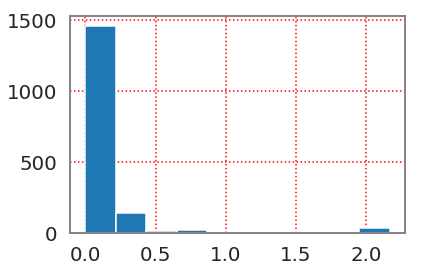

In [27]:
n, _, _ = plt.hist(twiss['l'], bins=10);
# assert n[0] - 1 == np.sum(n[1:])

# Preparing PyHEADTAIL beam

In [28]:
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, e, m_p, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
)

# Preparing PySTL for GPU

In [29]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [30]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [31]:
# assert (
#     len(elements.get_elements()) // 2 + 1 == 
#     len(madx.sequence.FODO.elements)
# ), ( 
#     "Did not generate the same number of PySixTrackLib "
#     "lattice elements as there are in the MAD-X lattice! "
#     "This will mess up the computation of SC node lengths..."
# )

$\longrightarrow$ start with a 0-length drift (FODO\\$START marker) and end with a 0-length drift (FODO\\$END marker), otherwise have $(\text{number of multipoles/non-drifts}) + 1$ drifts

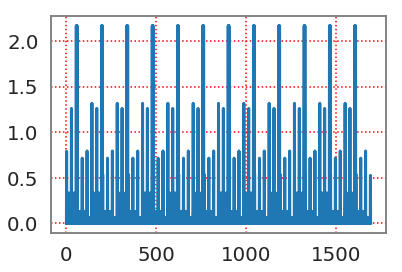

In [32]:
plt.plot(list(map(lambda e: e.length, elements.get_elements())))

In [33]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.FODO.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'D_x': twiss['dx'][idx_mad_sc],
    'D_y': twiss['dy'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [34]:
# PySTL contains both drifts and non-drifts in lattice as opposed to MAD-X:
idx_pyst_sc = map(lambda x: 2*x, idx_mad_sc)

In [35]:
idx_pyst_zerodrifts = [
    i for i, el in enumerate(elements.get_elements()) 
    if isinstance(el, pyst.DriftExact) and el.length == 0
]

In [36]:
# # all MAD-X sc_placeholders correspond to a zero-length drift in PySTL
# # (but there are more empty drifts than sc_placeholders)
# assert set(idx_pyst_sc).issubset(set(idx_pyst_zerodrifts))

In [37]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

# Interface to PyHEADTAIL

In [38]:
class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
#         pyht_beam.sort_for('id')
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [39]:
def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [40]:
sig_x = rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).max()
sig_y = rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).max()

In [41]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_x - rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).min()) / sig_x * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_y - rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).min()) / sig_y * 100))

The smallest horizontal beam size is 44.10% smaller than the largest beam size.
The smallest vertical beam size is 45.78% smaller than the largest beam size.


In [42]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=4) #z_cuts=slicing_interval)

In [43]:
mesh_3d = create_3dmesh_from_beam(pyht_beam, [n_mesh_nodes]*2, [n_mesh_sigma]*2, 
                                  slices=pyht_beam.get_slices(slicer_sc))

In [44]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [45]:
circumference

216.7081404

In [46]:
sum(el.length for el in elements.get_elements() if isinstance(el, pyst.DriftExact))

216.7081404

Assemble the one turn map with interleaved `PySixTrackLib` single-particle tracking and `PyHEADTAIL` space charge nodes:

In [47]:
one_turn_map = []

relevant_elements = elements.get_elements()

if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    relevant_elements = relevant_elements[:-1]

i_last = 0
length_covered = 0
for i_curr, el in enumerate(relevant_elements):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length

    #i_curr == 0 or 
    if el.length != 0 : # only inject SC node at markers (for SC)
        continue

    pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr
    length_covered = 0

assert pyst_node.i_end == len(relevant_elements)
assert el._offset == relevant_elements[-1]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

# Tracking space charge and full optics:

Let's track:

In [48]:
n_turns = 128 - 1

# coherent (centroid) motion
rec_x = np.empty(n_turns + 1, dtype=float)
rec_y = np.empty_like(rec_x)

rec_x[0] = pyht_beam.mean_x()
rec_y[0] = pyht_beam.mean_y()

# incoherent (1000 particles) motion
rec_inc_x = np.empty((n_turns+1, 1000), dtype=float)
rec_inc_y = np.empty_like(rec_inc_x)

pyht_beam.sort_for('id')
rec_inc_x[0, :] = pyht_beam.x[:1000]
rec_inc_y[0, :] = pyht_beam.y[:1000]

with GPU(pyht_beam):
    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)
            
        rec_x[i] = pyht_beam.mean_x().get()
        rec_y[i] = pyht_beam.mean_y().get()

        pyht_beam.sort_for('id')
        rec_inc_x[i, :] = pyht_beam.x[:1000].get()
        rec_inc_y[i, :] = pyht_beam.y[:1000].get()

        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

Turn 127/127

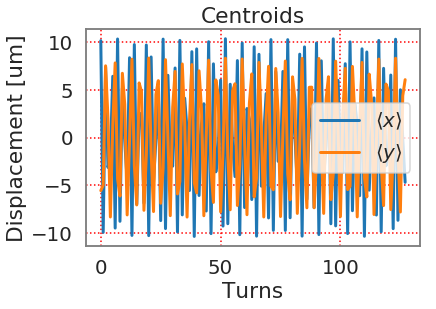

In [49]:
plt.plot(rec_x * 1e6, label=r'$\langle x \rangle$')
plt.plot(rec_y * 1e6, label=r'$\langle y \rangle$')
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Displacement [um]')
plt.title('Centroids');

Since we are using a self-consistent particle-in-cell model for space charge, the centroid must not show any incoherent frequency content, which is indeed the case (the orange lines are the TWISS tune, i.e. the bare machine tune):

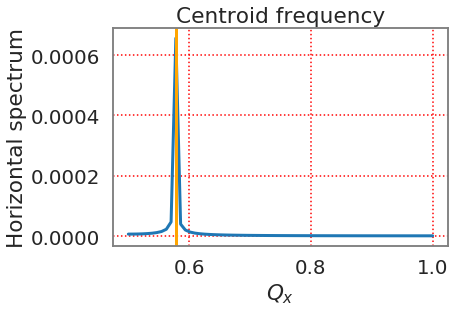

In [50]:
plt.plot(1 - np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_x)))
plt.axvline(twiss.summary['q1']%1, color='orange')
plt.xlabel('$Q_x$')
plt.ylabel('Horizontal spectrum')
plt.title('Centroid frequency');

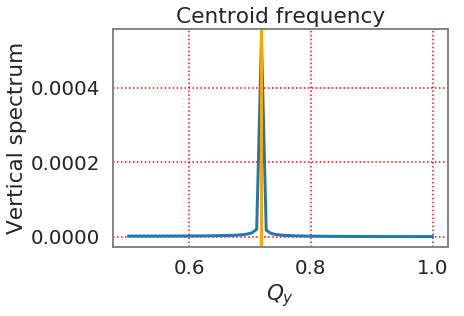

In [51]:
plt.plot(1 - np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_y)))
plt.axvline(twiss.summary['q2']%1, color='orange')
plt.xlabel('$Q_y$')
plt.ylabel('Vertical spectrum')
plt.title('Centroid frequency');

Emittances did not change over the simulation:

In [52]:
pyht_beam.epsn_x() / epsn_x

0.9988219337478174

In [53]:
pyht_beam.epsn_y() / epsn_y

0.9991993487317237

All particles still alive? (i.e. none eaten by `PySixTrackLib`'s global aperture):

In [54]:
all(pyst_beam.state)

True

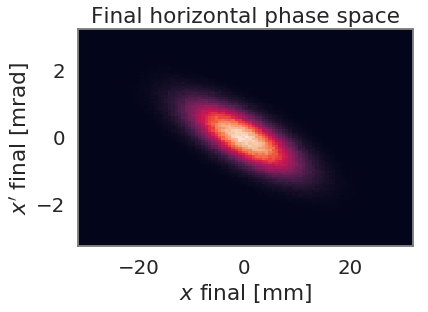

In [55]:
plt.hist2d(pyht_beam.x*1e3, pyht_beam.xp*1e3, bins=100)
plt.xlabel('$x$ final [mm]')
plt.ylabel('$x\'$ final [mrad]')
plt.title('Final horizontal phase space');

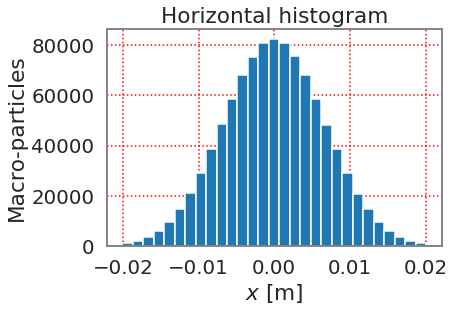

In [56]:
plt.hist(pyht_beam.x, bins=np.linspace(-pyht_beam.sigma_x()*3, pyht_beam.sigma_x()*3, 30));
plt.xlabel('$x$ [m]')
plt.ylabel('Macro-particles')
plt.title('Horizontal histogram');

In [57]:
assert all([all(pyht_beam.x), all(pyht_beam.xp), all(pyht_beam.y), all(pyht_beam.yp), all(pyht_beam.z)])

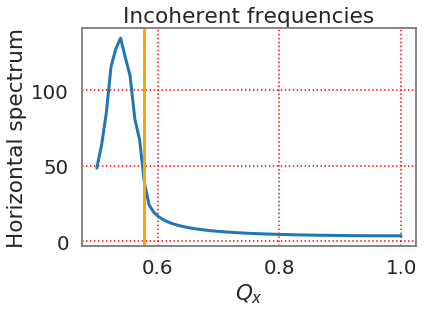

In [58]:
plt.plot(1 - np.fft.rfftfreq(n_turns+1), np.sum(np.abs(np.fft.rfft(rec_inc_x, axis=0)), axis=1))
plt.axvline(twiss.summary['q1']%1, color='orange')
plt.xlabel('$Q_x$')
plt.ylabel('Horizontal spectrum')
plt.title('Incoherent frequencies');

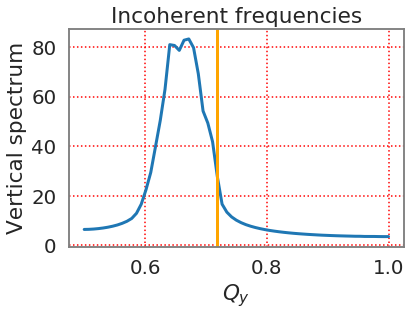

In [59]:
plt.plot(1 - np.fft.rfftfreq(n_turns+1), np.sum(np.abs(np.fft.rfft(rec_inc_y, axis=0)), axis=1))
plt.axvline(twiss.summary['q2']%1, color='orange')
plt.xlabel('$Q_y$')
plt.ylabel('Vertical spectrum')
plt.title('Incoherent frequencies');